In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import imread, generic_filter
from scipy.misc import imresize
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
%matplotlib inline

In [2]:
def load_data():
    lesion = []
    skin = []
    for folder in os.listdir('data'):
        if os.path.isdir(os.path.join('data', folder)):
            image = imread(os.path.join('data', folder, folder + '.bmp')) 
            mask = imread(os.path.join('data', folder, folder + '_lesion.bmp'))
            lesion_mask = mask > 100
            skin_mask = mask < 100
            for row in image[lesion_mask]:
                lesion.append(row)
            for row in image[skin_mask]:
                skin.append(row)
        
    return (np.array(lesion), np.array(skin))

In [3]:
(lesion, skin) = load_data()

In [4]:
X = np.mat(np.concatenate((lesion, skin), axis=0))
y = np.mat(np.concatenate((np.full(len(lesion), 1), np.zeros(len(skin))), axis=0)).T

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(28435641, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X_train[0:10,:]

matrix([[240, 141, 109],
        [178, 114,  79],
        [235, 179, 102],
        [ 94,  83,  77],
        [172,  93,  60],
        [187, 140, 103],
        [148,  91,  65],
        [ 98,  54,  27],
        [155, 135, 124],
        [251, 218, 210]], dtype=uint8)

In [10]:
print("Train dataset size: %d" % len(X_train))
print("Test dataset size: %d" % len(X_test))

Train dataset size: 59069426
Test dataset size: 29093897


In [20]:
train_size = 1000000
test_size = 1000000

In [21]:
logreg = linear_model.LogisticRegression(C=1e4)
logreg.fit(X_train[0:train_size,:], y_train[0:train_size,:])

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
accuracy = logreg.score(X_test[0:test_size,:], y_test[0:test_size,:])
print('Accuracy: %f' % accuracy)

Accuracy: 0.848069


In [33]:
def blur_image(img):
    footprint = np.array([[1,1,1],
                          [1,1,1],
                          [1,1,1]])
    return generic_filter(img, lambda values: nd.mean(values), footprint=footprint)

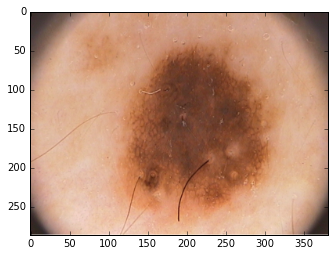

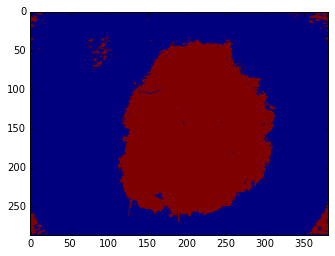

In [37]:
img = imresize(imread('examples/IMD002.bmp'), 0.5)
(x,y,c) = img.shape
points = img.reshape(x * y, c)
labels = logreg.predict(points)
labeled_img = labels.reshape(x, y)
plt.imshow(img)
plt.show()
plt.imshow(labeled_img)